In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns 
import math
import statistics
import random

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import adjusted_rand_score, v_measure_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split

from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [2]:
def var_threshold_selection(data, threshold=0.0):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

# Create and re-normalize data set with cell counts

In [41]:
from pathlib import Path
path = os.getcwd()
base_dir = str(Path(path).parent)

switch_isogenic_labels = True
human_only=True

norm_all_features = pd.read_csv(base_dir + '/3.analysis/feature_sets/Progenitors/0808_norm_data_all_features.csv', index_col=0)
norm_all_features = var_threshold_selection(norm_all_features)

df_data = pd.read_csv(base_dir + '/3.analysis/feature_sets/Progenitors/0714_stdev_corr_fs.csv', index_col=0)
data_cols = df_data.columns.tolist()

data = norm_all_features[data_cols]
cell_counts = norm_all_features['Cells_Number_Object_Number']

In [42]:
data_residuals = data.copy()
cell_count_corrs = pd.DataFrame()
features = data.columns.tolist()

# For every feature, get the linear regression and replace value with the residual
for feature in features:
    reg = LinearRegression().fit(data[feature].values.reshape(-1,1), cell_counts.values.reshape(-1,1))
    rscore = reg.score(data[feature].values.reshape(-1,1), cell_counts.values.reshape(-1,1))
    cell_count_corrs.loc[feature, 'r-squared'] = rscore
    cell_count_corrs.loc[feature, 'slope'] = reg.coef_
    cell_count_corrs.loc[feature, 'intercept'] = reg.intercept_
    
    # Find predicted feature value based on cell count
    predicted = reg.predict(data[feature].values.reshape(-1,1)).flatten()
    residuals = data[feature].values - predicted
    data_residuals[feature] = residuals

In [5]:
cell_count_corrs.sort_values(by='r-squared', ascending=False).head(10)

,r-squared,slope,intercept
Cytoplasm_Texture_Correlation_DNA_20_01,0.809411,-0.899673,-1.528556e-16
Nuclei_Neighbors_NumberOfNeighbors_2,0.785236,0.886135,1.083022e-16
Cells_Correlation_Correlation_DNA_Mito,0.782165,-0.884401,-2.043195e-16
Cells_Correlation_Overlap_ER_Brightfield,0.704664,0.839443,-1.896264e-15
Cytoplasm_Texture_InfoMeas1_RNA_10_00,0.690660,-0.831060,-2.645552e-16
Cells_RadialDistribution_RadialCV_ER_1of4,0.672240,-0.819903,-5.016942e-17
Cells_Intensity_LowerQuartileIntensity_DNA,0.669083,0.817975,1.271031e-17
Cells_Correlation_K_Brightfield_RNA,0.667023,0.816715,-2.051419e-16
Cells_RadialDistribution_RadialCV_DNA_1of4,0.644817,-0.803005,-4.536764e-16
Cytoplasm_RadialDistribution_MeanFrac_ER_4of4,0.633388,0.795857,8.493695e-16


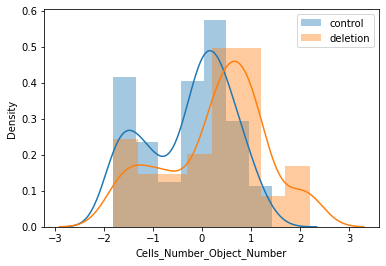

In [6]:
# Distribution of Cell counts vs control or deletion

temp = norm_all_features.copy()
temp['group'] = temp.index.str.split('_').map(lambda x: x[1])
temp = temp[['group', 'Cells_Number_Object_Number']]


sns.distplot(temp[temp['group']=='control']['Cells_Number_Object_Number'], label='control')
sns.distplot(temp[temp['group']=='deletion']['Cells_Number_Object_Number'], label='deletion')
plt.legend()
plt.show()

In [49]:
data_residuals['qq'] = norm_all_features['Cells_Number_Object_Number']
data_residuals[data_residuals['qq'] < -1.4].sort_index()


,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MaximumRadius,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_1_1,...,Cells_RadialDistribution_FracAtD_RNA_1of4,Cells_RadialDistribution_FracAtD_RNA_4of4,Cells_RadialDistribution_RadialCV_RNA_1of4,Cytoplasm_RadialDistribution_FracAtD_RNA_1of4,Cytoplasm_RadialDistribution_FracAtD_RNA_3of4,Cytoplasm_RadialDistribution_FracAtD_RNA_4of4,Cytoplasm_RadialDistribution_MeanFrac_RNA_1of4,Cytoplasm_RadialDistribution_MeanFrac_RNA_4of4,Nuclei_RadialDistribution_RadialCV_RNA_1of4,qq
human_control_12_I12,4.885511,-0.404582,0.301909,0.118326,-4.888474,-0.237646,-1.460794,7.799412,0.213908,-0.318222,...,-1.524324,0.417879,2.047413,3.482825,5.195741,-3.681599,-0.038267,-0.369903,-3.248956,-1.541537
human_control_12_J11,5.132057,-0.967584,0.430257,0.244015,-4.159770,-0.264735,-1.307625,6.747384,-0.068557,-0.794887,...,-1.425505,0.389982,1.821494,3.446563,4.907823,-3.477255,0.149798,-0.333424,-3.196552,-1.475920
human_control_16_M08,17.054062,-1.133904,0.052251,-0.019797,-12.391906,0.157194,-1.685945,15.814574,-0.027152,-1.089726,...,-2.004648,0.564988,1.885637,2.967882,5.406993,-3.710547,-0.334134,-0.321108,-3.866657,-1.682135
human_control_16_N07,12.942098,-0.347573,0.133220,0.018810,-7.494685,-0.029193,-1.623571,12.488122,0.322063,-0.916758,...,-2.052754,0.601881,-0.069300,3.082578,5.239695,-3.612489,-0.693672,-0.188796,-3.968947,-1.635278
human_control_16_N08,6.820465,-0.488418,0.224365,0.193911,-5.827094,-0.040224,-1.509455,9.471984,-0.081623,-0.635363,...,-1.870657,0.510074,1.999234,3.546356,5.470133,-3.831207,-0.098646,-0.364357,-3.671791,-1.561375
human_control_21_G13,0.017877,-0.918973,0.679288,-0.468652,0.321386,0.012804,-0.028474,0.810185,0.412498,0.143707,...,2.704542,-0.377144,1.849589,0.898845,0.506046,-0.470856,1.929889,-0.308347,0.568677,-1.400516
human_control_21_G14,0.077899,0.419120,1.780029,-0.136630,0.625063,-0.418919,-0.397627,0.932898,0.328967,0.058886,...,2.393361,-0.360691,1.946424,0.779884,0.629446,-0.519159,2.620831,-0.364149,0.766661,-1.525796
human_control_21_H13,0.097179,-0.933871,0.834464,-0.418221,0.439241,-0.019864,-0.067913,1.067443,-0.137986,0.122863,...,2.504928,-0.400756,1.759459,0.488650,0.709068,-0.499901,1.519745,-0.302313,0.309975,-1.529909
human_control_21_H14,0.085975,-0.885854,2.287366,0.155887,-0.059672,-0.707018,-0.708898,0.896987,-0.082302,0.034969,...,1.755991,-0.256223,2.281701,1.054520,0.543357,-0.526459,2.312448,-0.297683,0.150342,-1.460790
human_control_21_O11,0.272076,0.452060,3.162465,0.474182,1.058959,-1.317818,-1.256089,1.416669,-0.447142,-0.094969,...,1.625370,-0.236762,2.276994,2.018160,1.601423,-1.329307,3.727156,-0.475819,-0.863653,-1.553430


# Logistic Regression on residuals data

In [7]:
# residuals is the df of residualsalized features
residuals = data_residuals.copy()
residuals = residuals[data_cols]

human_only = True
if human_only:
    residuals = residuals[residuals.index.str.startswith('human')]


to_exclude = True
if to_exclude:
    residuals['cell_count'] = cell_counts
    residuals = residuals[residuals['cell_count'] > -1.39]
    residuals = residuals.drop(['cell_count'], axis=1)
    
swap_isogenic = True
labels = residuals.index.tolist()
if swap_isogenic:
    for i in range(len(labels)):
        if 'isogenic_deletion' in labels[i]:
            labels[i] = labels[i].replace('isogenic_deletion', 'temp')
    for i in range(len(labels)):
        if 'isogenic_control' in labels[i]:
            labels[i] = labels[i].replace('isogenic_control', 'isogenic_deletion')            
        if 'temp' in labels[i]:
            labels[i] = labels[i].replace('temp', 'isogenic_control')                    
residuals.index = labels

residuals['label'] = residuals.index.str.split('_').map(lambda x: x[1])
residuals_xtrain, residuals_xtest, residuals_ytrain, residuals_ytest = train_test_split(residuals.drop(['label'], axis=1), residuals['label'], 
                                                                    test_size=0.3, random_state=4)
print(len(residuals_xtrain), len(residuals_xtest))

logr = LogisticRegression(random_state=12, penalty='l2', C=1, max_iter=100).fit(residuals_xtrain, residuals_ytrain)
print(logr.score(residuals_xtrain, residuals_ytrain), logr.score(residuals_xtest, residuals_ytest))


residuals_xtrain

205 89
0.9951219512195122 0.9438202247191011


,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MaximumRadius,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_1_1,...,Nuclei_Intensity_StdIntensityEdge_RNA,Cells_RadialDistribution_FracAtD_RNA_1of4,Cells_RadialDistribution_FracAtD_RNA_4of4,Cells_RadialDistribution_RadialCV_RNA_1of4,Cytoplasm_RadialDistribution_FracAtD_RNA_1of4,Cytoplasm_RadialDistribution_FracAtD_RNA_3of4,Cytoplasm_RadialDistribution_FracAtD_RNA_4of4,Cytoplasm_RadialDistribution_MeanFrac_RNA_1of4,Cytoplasm_RadialDistribution_MeanFrac_RNA_4of4,Nuclei_RadialDistribution_RadialCV_RNA_1of4
human_control_17_D01,-0.088572,-0.134801,1.040848,0.390880,0.073144,-0.568841,-0.432861,-0.003897,-0.221388,0.037046,...,1.165743,0.037255,-0.038572,1.171003,-0.163502,-0.179353,0.143016,0.478912,-0.031893,0.784643
human_deletion_34_M15,-0.339316,-0.040766,-1.032028,-0.049713,-0.171063,0.502622,0.372524,-1.244729,0.002550,-0.075117,...,-1.776330,-1.469482,0.322277,-4.021212,-0.795947,-0.571037,0.494917,-1.963327,0.296951,-3.134578
human_control_12_A23,-0.059359,0.109713,-0.235397,0.182232,-2.103010,-0.009774,-0.187627,0.052965,-0.055165,-0.141827,...,-0.540142,-1.191521,0.256831,0.372909,0.354775,0.537465,-0.382909,-0.731664,0.047260,0.884012
human_control_13_O19,-0.020893,-0.051262,-0.474550,0.066604,-1.015803,0.096172,-0.134774,0.196932,0.285167,-0.088032,...,-0.823064,-1.159375,0.232859,0.560850,0.347106,0.657275,-0.441425,-0.775238,0.061245,0.613589
human_deletion_35_H04,-0.262764,-0.002889,-1.026860,-0.052368,-0.193809,0.481035,0.462184,-1.029944,0.209350,0.058128,...,-1.467509,-1.286906,0.268846,-3.675255,-0.161852,0.191032,-0.067190,-1.985531,0.307712,-3.106989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
human_deletion_38_C15,-0.334194,-0.117504,-0.986492,0.074499,-0.188061,0.460087,0.450129,-1.155831,0.000195,-0.042579,...,-1.404384,-1.296179,0.263795,-3.413857,-1.165291,-1.319015,0.996389,-1.773643,0.292091,-2.448644
human_deletion_29_D24,-0.218908,0.016580,-0.800593,-0.011662,0.165780,0.209757,0.168222,-0.441328,0.005126,0.158760,...,-0.407173,-0.944651,0.167045,-0.809711,-0.279193,-0.232748,0.190085,-0.898611,0.088756,-0.048235
human_deletion_40_K04,-0.023129,-0.018851,-0.585279,0.041124,-1.689182,0.199336,-0.158833,0.180154,0.016036,-0.174574,...,-1.324226,-1.439594,0.329942,0.080413,0.063655,0.441401,-0.254567,-1.285083,0.159611,0.597898
human_deletion_42_I22,-0.234012,0.044492,-0.481462,0.224735,0.311699,0.152114,0.222446,-0.552004,0.109505,-0.000946,...,0.378232,-0.533385,0.046636,-0.702381,-0.155973,-0.213184,0.151324,-0.360753,0.017521,-0.016396


In [8]:
# residuals is the df of residualsalized features
residuals = data_residuals.copy()
residuals = residuals[data_cols]

human_only = True
if human_only:
    residuals = residuals[residuals.index.str.startswith('human')]


to_exclude = True
if to_exclude:
    residuals['cell_count'] = cell_counts
    residuals = residuals[residuals['cell_count'] > -1.39]
    residuals = residuals.drop(['cell_count'], axis=1)
    
swap_isogenic = False
labels = residuals.index.tolist()
if swap_isogenic:
    for i in range(len(labels)):
        if 'isogenic_deletion' in labels[i]:
            labels[i] = labels[i].replace('isogenic_deletion', 'temp')
    for i in range(len(labels)):
        if 'isogenic_control' in labels[i]:
            labels[i] = labels[i].replace('isogenic_control', 'isogenic_deletion')            
        if 'temp' in labels[i]:
            labels[i] = labels[i].replace('temp', 'isogenic_control')                    
residuals.index = labels

random.seed(3)
residuals['label'] = residuals.index.str.split('_').map(lambda x: x[1])
residuals['patient_num'] = residuals.index.str.split('_').map(lambda x: x[2])

patients = list(set(residuals['patient_num']))
random.shuffle(patients)
train_nums = patients[0:30]
test_nums = patients[30:]

train_df = residuals[residuals['patient_num'].isin(train_nums)]
test_df = residuals[residuals['patient_num'].isin(test_nums)]

residuals_xtrain = train_df.drop(['label', 'patient_num'], axis=1)
residuals_ytrain = train_df['label']
residuals_xtest = test_df.drop(['label', 'patient_num'], axis=1)
residuals_ytest = test_df['label']
print(len(residuals_xtrain), len(residuals_ytrain), len(residuals_xtest), len(residuals_ytest))

logr = LogisticRegression(random_state=12, penalty='l2', C=1, max_iter=100).fit(residuals_xtrain, residuals_ytrain)
print(logr.score(residuals_xtrain, residuals_ytrain), logr.score(residuals_xtest, residuals_ytest))

222 222 72 72
1.0 0.7222222222222222


# Run split 100 times, human only, exclude low cell ct

In [36]:
# RANDOM SPLIT SKLEARN

# residuals is the df of residualsalized features
residuals = data_residuals.copy()
residuals = residuals[data_cols]

human_only = True
if human_only:
    residuals = residuals[residuals.index.str.startswith('human')]

to_exclude = True
if to_exclude:
    residuals['cell_count'] = cell_counts
    residuals = residuals[residuals['cell_count'] > -1.39]
    residuals = residuals.drop(['cell_count'], axis=1)
    
residuals['label'] = residuals.index.str.split('_').map(lambda x: x[1])
residuals_100_trials_random_split = pd.DataFrame(columns=['x_train', 'x_test', 'y_train', 'y_test', 'train_acc', 'test_acc'])    
for i in range(100):
    residuals_xtrain, residuals_xtest, residuals_ytrain, residuals_ytest = train_test_split(residuals.drop(['label'], axis=1), residuals['label'], 
                                                                    test_size=0.3, random_state=i)
#     print(len(residuals_xtrain), len(residuals_ytrain), len(residuals_xtest), len(residuals_ytest))
    logr = LogisticRegression(random_state=12, penalty='l2', C=1, max_iter=100).fit(residuals_xtrain, residuals_ytrain)
#     print(logr.score(residuals_xtrain, residuals_ytrain), logr.score(residuals_xtest, residuals_ytest))
    residuals_100_trials_random_split.loc[len(residuals_100_trials_random_split.index)] = \
        [len(residuals_xtrain), len(residuals_ytrain), len(residuals_xtest), len(residuals_ytest), 
         logr.score(residuals_xtrain, residuals_ytrain), logr.score(residuals_xtest, residuals_ytest)]

In [10]:
# SPLIT BASED ON CELL LINE

# residuals is the df of residualsalized features
residuals = data_residuals.copy()
residuals = residuals[data_cols]

human_only = True
if human_only:
    residuals = residuals[residuals.index.str.startswith('human')]


to_exclude = True
if to_exclude:
    residuals['cell_count'] = cell_counts
    residuals = residuals[residuals['cell_count'] > -1.39]
    residuals = residuals.drop(['cell_count'], axis=1)

residuals_100_trials_patient_split = pd.DataFrame(columns=['x_train', 'x_test', 'y_train', 'y_test', 'train_acc', 'test_acc'])    
for i in range(100):
    random.seed(i)
    residuals['label'] = residuals.index.str.split('_').map(lambda x: x[1])
    residuals['patient_num'] = residuals.index.str.split('_').map(lambda x: x[2])

    patients = list(set(residuals['patient_num']))
    split_cut = math.ceil(0.7 * len(patients))

    random.shuffle(patients)
    train_nums = patients[0:split_cut]
    test_nums = patients[split_cut:]

    train_df = residuals[residuals['patient_num'].isin(train_nums)]
    test_df = residuals[residuals['patient_num'].isin(test_nums)]

    residuals_xtrain = train_df.drop(['label', 'patient_num'], axis=1)
    residuals_ytrain = train_df['label']
    residuals_xtest = test_df.drop(['label', 'patient_num'], axis=1)
    residuals_ytest = test_df['label']
#     print(len(residuals_xtrain), len(residuals_ytrain), len(residuals_xtest), len(residuals_ytest))

    logr = LogisticRegression(random_state=12, penalty='l2', C=1, max_iter=100).fit(residuals_xtrain, residuals_ytrain)
#     print(logr.score(residuals_xtrain, residuals_ytrain), logr.score(residuals_xtest, residuals_ytest))
    residuals_100_trials_patient_split.loc[len(residuals_100_trials_patient_split.index)] = \
        [len(residuals_xtrain), len(residuals_ytrain), len(residuals_xtest), len(residuals_ytest), 
         logr.score(residuals_xtrain, residuals_ytrain), logr.score(residuals_xtest, residuals_ytest)]


# Logistic Regression on straight up data

In [11]:
# SPLIT WITH SKLEARN

# norm is the df of normalized features
norm = norm_all_features.copy()
norm = norm[data_cols]

human_only = True
if human_only:
    norm = norm[norm.index.str.startswith('human')]


to_exclude = True
if to_exclude:
    norm['cell_count'] = cell_counts
    norm = norm[norm['cell_count'] > -1.39]
    norm = norm.drop(['cell_count'], axis=1)
    
swap_isogenic = False
labels = norm.index.tolist()
if swap_isogenic:
    for i in range(len(labels)):
        if 'isogenic_deletion' in labels[i]:
            labels[i] = labels[i].replace('isogenic_deletion', 'temp')
    for i in range(len(labels)):
        if 'isogenic_control' in labels[i]:
            labels[i] = labels[i].replace('isogenic_control', 'isogenic_deletion')            
        if 'temp' in labels[i]:
            labels[i] = labels[i].replace('temp', 'isogenic_control')                    
norm.index = labels
    
norm['label'] = norm.index.str.split('_').map(lambda x: x[1])
norm_xtrain, norm_xtest, norm_ytrain, norm_ytest = train_test_split(norm.drop(['label'], axis=1), norm['label'], 
                                                                    test_size=0.3, random_state=4)
print(len(norm_xtrain), len(norm_xtest), len(norm_ytrain), len(norm_ytest))

logr2 = LogisticRegression(random_state=2, penalty='l2', C=1, max_iter=130).fit(norm_xtrain, norm_ytrain)
print(logr2.score(norm_xtrain, norm_ytrain), logr2.score(norm_xtest, norm_ytest))

205 89 205 89
1.0 0.9550561797752809


In [12]:
# SPLIT BASED ON PATIENT NUMBER

#norm is the df of normalized features
norm = norm_all_features.copy()
norm = norm[data_cols]

human_only = True
if human_only:
    norm = norm[norm.index.str.startswith('human')]


to_exclude = False
if to_exclude:
    norm['cell_count'] = cell_counts
    norm = norm[norm['cell_count'] > -1.39]
    norm = norm.drop(['cell_count'], axis=1)
    
swap_isogenic = False
labels = norm.index.tolist()
if swap_isogenic:
    for i in range(len(labels)):
        if 'isogenic_deletion' in labels[i]:
            labels[i] = labels[i].replace('isogenic_deletion', 'temp')
    for i in range(len(labels)):
        if 'isogenic_control' in labels[i]:
            labels[i] = labels[i].replace('isogenic_control', 'isogenic_deletion')            
        if 'temp' in labels[i]:
            labels[i] = labels[i].replace('temp', 'isogenic_control')                    
norm.index = labels
    
# random.seed(3)
norm['label'] = norm.index.str.split('_').map(lambda x: x[1])
norm['patient_num'] = norm.index.str.split('_').map(lambda x: x[2])

patients = list(set(norm['patient_num']))
random.shuffle(patients)
train_nums = patients[0:36]
test_nums = patients[36:]

train_df = norm[norm['patient_num'].isin(train_nums)]
test_df = norm[norm['patient_num'].isin(test_nums)]

norm_xtrain = train_df.drop(['label', 'patient_num'], axis=1)
norm_ytrain = train_df['label']
norm_xtest = test_df.drop(['label', 'patient_num'], axis=1)
norm_ytest = test_df['label']
print(len(norm_xtrain), len(norm_ytrain), len(norm_xtest), len(norm_ytest))

logr2 = LogisticRegression(random_state=2, penalty='l2', C=1, max_iter=130).fit(norm_xtrain, norm_ytrain)
print(logr2.score(norm_xtrain, norm_ytrain), logr2.score(norm_xtest, norm_ytest))

284 284 64 64
1.0 0.71875
